# <center> News classification with ULMFiT. Starter

Here we mostly follow the training scheme described by Jeremy Howard in [fast.ai Lesson 4](https://course.fast.ai/videos/?lesson=4): taking a pretrained language model, fine-tuning it with unlabeled data, then fine-tuning classification head for our particular task.

This is just a starter. At each step, I also mention how you can do better.

In [1]:
from tqdm import tqdm_notebook
import torch
import fastai
from fastai.text import *
fastai.__version__

'1.0.52'

In [2]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from time import sleep

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from fastai.text import learner

In [5]:
# learner._model_meta[AWD_LSTM]['config_lm']['qrnn'] = True
# learner._model_meta[AWD_LSTM]['config_clas']['qrnn'] = True

In [6]:
! pip install ninja

In [7]:
! pip install sentencepiece

In [8]:
import sentencepiece as spm

# Preprocessing
Here we write all news texts from train, validation and text files into `unlabeled_news.csv` - to train a language model.

Then, we write texts and labels into `train_28k.csv` and texts only into `test_5k.csv`.

**How to do better:** go for that 80k unlabeled set as well.

In [9]:
comments = pd.read_csv("tutby/train.csv").rename(columns={"comment": "text"})

In [7]:
train, test = train_test_split(comments, test_size=0.3)
valid, test = train_test_split(test, test_size=0.3)

In [8]:
train.to_csv("./train.csv")

In [9]:
test.to_csv("./test.csv")

In [10]:
valid.to_csv("./valid.csv")

In [11]:
train = pd.read_csv('./train.csv').fillna(' ')
valid = pd.read_csv('./valid.csv').fillna(' ')
test = pd.read_csv('./test.csv').fillna(' ')

In [13]:
pd.concat([train['text'], valid['text'], test['text']]).to_csv('unlabeled_news.csv', index=None, header=True)

In [14]:
pd.concat([train[['text', 'label']],valid[['text', 'label']]]).to_csv('train_28k.csv', index=None, header=True)
test[['text']].to_csv('test_5k.csv', index=None, header=True)

In [22]:
folder = '.'
unlabeled_file = 'unlabeled_news.csv'

# Train BPE tokenizer

In [8]:
comments = pd.read_csv("unlabeled_news.csv")

In [23]:
with open('unlabeled.txt', "w", encoding="utf-8") as file:
    for message in tqdm_notebook(comments["text"]):
        message = message.replace("\n", "").replace("\r", "") + "\n"
        file.write(message)

- UNK (xxunk) is for an unknown word (one that isn't present in the current vocabulary)
- PAD (xxpad) is the token used for padding, if we need to regroup several texts of different lengths in a batch
- BOS (xxbos) represents the beginning of a text in your dataset
- FLD (xxfld) is used if you set mark_fields=True in your TokenizeProcessor to separate the different fields of texts (if your texts are loaded from several columns in a dataframe)
- TK_MAJ (xxmaj) is used to indicate the next word begins with a capital in the original text
- TK_UP (xxup) is used to indicate the next word is written in all caps in the original text
- TK_REP (xxrep) is used to indicate the next character is repeated n times in the original text (usage xxrep n {char})
- TK_WREP(xxwrep) is used to indicate the next word is repeated n times in the original text (usage xxwrep n {word})

In [24]:
spm.SentencePieceTrainer.Train('--input=unlabeled.txt --model_prefix=comments --vocab_size=20000 --control_symbols=xxunk,xxpad,xxbos,xxfld,xxmaj,xxup,xxrep,xxwrep')

True

# Create tokenizer

In [9]:
sp = spm.SentencePieceProcessor()

In [10]:
sp.Load('comments.model')

True

In [11]:
sp.EncodeAsPieces("умри животное xxbos")

['▁ум', 'ри', '▁животное', '▁', 'xx', 'bo', 's']

In [12]:
class BPETokenizer(BaseTokenizer):
    def tokenizer(self, text):
        return sp.EncodeAsPieces(text)

In [13]:
def return_tokenizer(*args, **kwargs):
    return BPETokenizer(*args, **kwargs)

In [14]:
tokenizer = Tokenizer(tok_func=return_tokenizer)

# Reading unlabeled data to train ULMFiT language model

In [36]:
data_lm = TextLMDataBunch.from_csv(folder, unlabeled_file, text_cols='text', tokenizer=tokenizer)

In [37]:
data_lm.save("ulmfit_data_lm_bpe")

In [15]:
data_lm = load_data("./", "ulmfit_data_lm_bpe", bs=32)

# LM training 

Here we resort to the training scheme described by Jeremy Howard, [fast.ai](https://course.fast.ai/):
 - finding good initial learning rate
 - training for one epoch
 - unfreezing and more training

**How to do better:** train for 10-15 epochs after unfreezing

In [16]:
learn = language_model_learner(data_lm, drop_mult=0.3, arch=AWD_LSTM, pretrained=False)

In [17]:
learn = learn.load("toxic_comments_language_model_1")

In [16]:
class MonitorCallback(LearnerCallback):
    period = 100
    def on_train_begin(self, **kwargs):
        self.fig = plt.figure()
        self.loss_ax = self.fig.add_subplot(111)
        plt.ion()
        self.fig.show()
        self.fig.canvas.draw()
    
    def on_batch_end(self, **kwargs):
        self.last_args = kwargs
        if (kwargs['num_batch'] % self.period == 0):
            self.loss_ax.clear()
            self.loss_ax.plot(self.learn.recorder.losses)
                        
            self.fig.canvas.draw()

In [17]:
class LMSampleCallback(LearnerCallback):
    period = 500
    messages = ['ломай меня полностью. я хочу, чтобы ты ломал', 'social weekend - это сборище']
    
    def on_batch_end(self, **kwargs):
        if (kwargs['num_batch'] % self.period == 0):
            self.learn.model.eval()
            for message in self.messages:
                print(self.learn.predict(message, n_words=20))
            self.learn.model.train()

In [18]:
class StopAfterNBatches(LearnerCallback):
    n_batches = 5000
    
    def on_batch_end(self, **kwargs):
        if (kwargs['num_batch'] > self.n_batches):
            return {'stop_epoch': True}

In [44]:
monitor_callback = MonitorCallback(learn)

In [45]:
sample_callback = LMSampleCallback(learn)

In [46]:
stop_after_n_batches = StopAfterNBatches(learn)

In [47]:
best_lm_lr = 6e-3

<IPython.core.display.Javascript object>


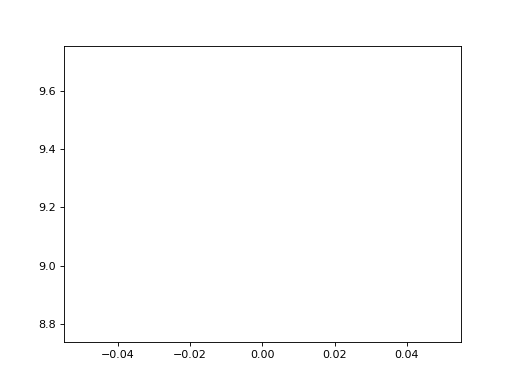

epoch,train_loss,valid_loss,accuracy,time
0,8.950622,8.544443,0.042857,00:04


ломай меня полностью. я хочу, чтобы ты ломал ству ▁болезнь чистить ду ▁виноваты ▁пик ▁оскорбление ▁бедолаг ▁пар ▁ооо ▁читал ▁бабка 94 ящего ▁матчасть ▁прожив чная ▁премьер ▁останавлива ▁городах
social weekend - это сборище ▁прикидыва ▁налогов ▁поздравляю рик евро ▁данной ▁предателя мудр ▁делали ▁электр аться ▁наказания ▁тьфу аешь ▁гражданам ой ▁гугл ▁рабы ▁:( ▁терпеть


In [27]:
learn.fit_one_cycle(5, best_lm_lr, callbacks=[monitor_callback, stop_after_n_batches, sample_callback])

In [47]:
learn.save_encoder('toxic_comments_enc')

In [48]:
learn.save("toxic_comments_language_model_1")

In [ ]:
learn.unfreeze()

<IPython.core.display.Javascript object>


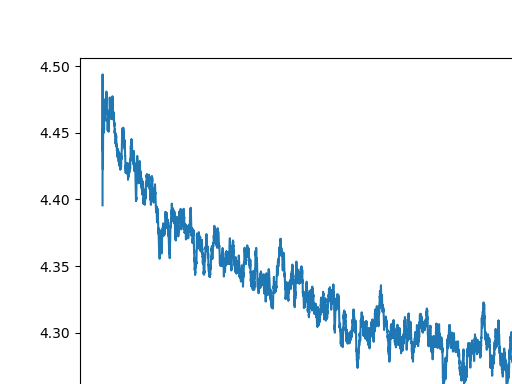

epoch,train_loss,valid_loss,accuracy,time
0,4.321750,4.692357,0.285714,09:25
1,4.288865,4.759747,0.285714,09:25


ломай меня полностью. я хочу, чтобы ты ломал ▁город ский ▁ком кри ли р ский ▁ ником ▁( в ▁которых ▁вы ▁были ▁на ▁высот е ) ▁или ▁у
social weekend - это сборище ▁умных ▁я ще ту ▁ xx re p ▁4 ▁. ▁ xx bo s ▁у ▁во лон тер а ▁еще
ломай меня полностью. я хочу, чтобы ты ломал ▁тебя ▁без дель никами ▁и ▁ смерт ностью ▁ xx bo s ▁украина ▁и ▁в ▁д ю м ур б
social weekend - это сборище ▁сообщений ▁20 ▁лет ▁на ▁этой ▁по мой ке , следователь на ▁i ▁вот ▁такие ▁вот ▁троли ▁ xx bo s
ломай меня полностью. я хочу, чтобы ты ломал ▁свою ▁ошиб ку . ▁ты ▁по йдет ▁на ▁свободу . ▁ты ▁уже ▁не ▁сп ишь ▁в ▁тюрьме . ▁мид ▁германии
social weekend - это сборище ▁яблок ов . ▁сша ▁- ▁страна ▁более ▁традицион ных ▁русскомир ных щик и . ▁пере черк ж аем ▁- ▁варвар
ломай меня полностью. я хочу, чтобы ты ломал ▁10 12 ▁твою ▁ко шка !) ▁ xx bo s ▁сказал ▁государственный ▁персонал 2 , а ▁теперь ▁бо ли чая
social weekend - это сборище ▁на клон стей ▁и ▁терпил . ▁ко ричнев ую ▁монгол о - та тар скую ▁к ли нику ▁от ложит
ломай 

KeyboardInterrupt: 

In [48]:
learn.fit_one_cycle(5, best_lm_lr, callbacks=[monitor_callback, stop_after_n_batches, sample_callback])

In [49]:
learn.save_encoder('toxic_comments_enc')

In [50]:
learn.save("toxic_comments_language_model_2")

# Generating some text

It's always interesting to see whether a LM is able to generate nice text. With LM training improvement (in terms of loss), at some point you'll notice some nice improvement in quality of the generated text.

One sample generated with my better-trained LM:

> 'An italian man was found dead in his yard due to heat conditions on Sunday night , his spokeswoman said . The office manager of the Ultra retired man ’s office told buzzfeed News there being no sign of comfort . The man at his 911 home told guy , he had been in contact with his car ’s owner before asleep and then immediately responded to starting fire . The man named Guy made a news video at PARKING Station in which the Mississippi State Police shot multiple people with Tim Shepherd to get their son alive , Mark Morris , a family friend dangling near his wife ’s house , said . The teen told police he was winning inclusion in general . Police dragged him into the house — where the officer had been yards away — during his die - hard bid at a nearby snow salon . The family voted in favor of Appreciative and arrested more than three months later : They tried to detained him . He and his family stopped , per the station , all the way up . “'

No much sense, but at least some structure :) And now with GPT-2 we see that quantitative improvements can also lead to qualital improvements.

# Training classification head

Here again we follow Jeremy Howard. 

**How to do better:** hyperparam tuning (though it's extremely annoying with such a heavy model), more epochs after unfreezing, check for some live examples of ULMFiT training, different learning rates for different layers etc.

In [19]:
class ClassificatorSampleCallback(LearnerCallback):
    period = 500
    messages = ['пожалуйста, позвольте мне пройти', 'ненавижу каждого из вас, горите в аду']
    
    def print_toxicity(self, text):
        print(text)
        print(self.learn.predict(text))
    
    def on_batch_end(self, **kwargs):
        self.learn.model.eval()
        if (kwargs['num_batch'] % self.period == 0):
            for message in self.messages:
                self.print_toxicity(message)
        self.learn.model.train()

In [20]:
train_file, test_file = 'train_28k.csv', 'test_5k.csv'

In [23]:
data_clas = TextClasDataBunch.from_csv(path=folder, 
                                        csv_name=train_file,
                                        test=test_file,
                                        vocab=data_lm.train_ds.vocab, 
                                        bs=32, # small batch size
                                        text_cols='text', 
                                        tokenizer=tokenizer,
                                        label_cols='label')

In [24]:
data_clas.save("ulmfit_data_clas")

In [21]:
data_clas = load_data("./", "ulmfit_data_clas", bs=16)

In [22]:
learn_clas = text_classifier_learner(data_clas, drop_mult=0.3, arch=AWD_LSTM)  

In [27]:
learn_clas.load_encoder('toxic_comments_enc')

In [28]:
monitor_callback = MonitorCallback(learn_clas)

In [29]:
sample_callback = ClassificatorSampleCallback(learn_clas)

In [30]:
stop_after_n_batches = StopAfterNBatches(learn_clas)

In [26]:
best_clf_lr = 3e-4

<IPython.core.display.Javascript object>


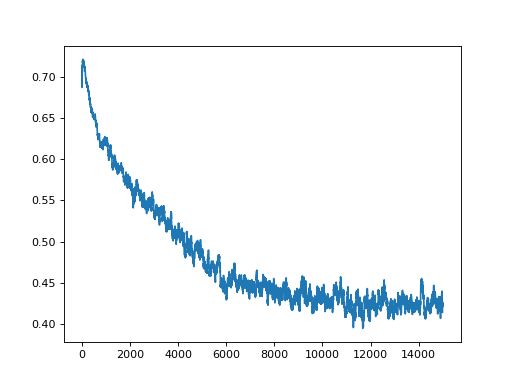

epoch,train_loss,valid_loss,accuracy,time
0,0.487119,0.446746,0.812500,04:06
1,0.434707,0.309655,0.812500,04:02
2,0.421962,0.323926,0.812500,03:55


пожалуйста, позвольте мне пройти
(Category False, tensor(0), tensor([0.5149, 0.4851]))
ненавижу каждого из вас, горите в аду
(Category False, tensor(0), tensor([0.5188, 0.4812]))
пожалуйста, позвольте мне пройти
(Category True, tensor(1), tensor([0.4054, 0.5946]))
ненавижу каждого из вас, горите в аду
(Category True, tensor(1), tensor([0.3705, 0.6295]))
пожалуйста, позвольте мне пройти
(Category True, tensor(1), tensor([0.4360, 0.5640]))
ненавижу каждого из вас, горите в аду
(Category True, tensor(1), tensor([0.2751, 0.7249]))
пожалуйста, позвольте мне пройти
(Category True, tensor(1), tensor([0.4512, 0.5488]))
ненавижу каждого из вас, горите в аду
(Category True, tensor(1), tensor([0.2267, 0.7733]))
пожалуйста, позвольте мне пройти
(Category True, tensor(1), tensor([0.4539, 0.5461]))
ненавижу каждого из вас, горите в аду
(Category True, tensor(1), tensor([0.1770, 0.8230]))
пожалуйста, позвольте мне пройти
(Category True, tensor(1), tensor([0.4425, 0.5575]))
ненавижу каждого из вас, го

In [32]:
learn_clas.fit_one_cycle(3, best_clf_lr, callbacks=[monitor_callback, sample_callback, stop_after_n_batches])

In [34]:
learn_clas.save("comments_model_2")

In [35]:
learn_clas.freeze_to(-2)

<IPython.core.display.Javascript object>


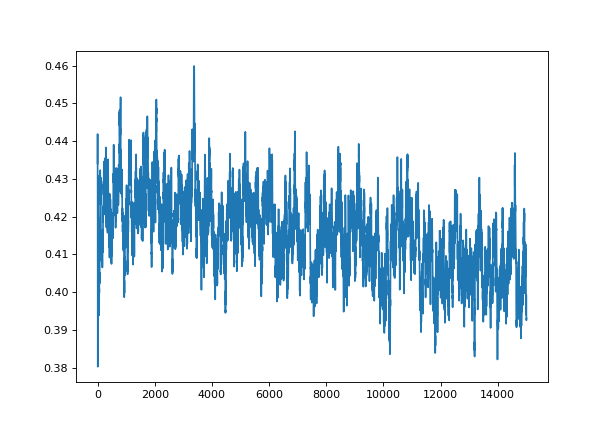

epoch,train_loss,valid_loss,accuracy,time
0,0.418587,0.247484,0.843750,04:33
1,0.400336,0.208566,0.968750,05:07
2,0.392328,0.177084,0.906250,04:43


пожалуйста, позвольте мне пройти
(Category False, tensor(0), tensor([0.5018, 0.4982]))
ненавижу каждого из вас, горите в аду
(Category True, tensor(1), tensor([0.0554, 0.9446]))
пожалуйста, позвольте мне пройти
(Category False, tensor(0), tensor([0.5151, 0.4849]))
ненавижу каждого из вас, горите в аду
(Category True, tensor(1), tensor([0.0461, 0.9539]))
пожалуйста, позвольте мне пройти
(Category True, tensor(1), tensor([0.4639, 0.5361]))
ненавижу каждого из вас, горите в аду
(Category True, tensor(1), tensor([0.0460, 0.9540]))
пожалуйста, позвольте мне пройти
(Category False, tensor(0), tensor([0.5585, 0.4415]))
ненавижу каждого из вас, горите в аду
(Category True, tensor(1), tensor([0.0492, 0.9508]))
пожалуйста, позвольте мне пройти
(Category True, tensor(1), tensor([0.4811, 0.5189]))
ненавижу каждого из вас, горите в аду
(Category True, tensor(1), tensor([0.0459, 0.9541]))
пожалуйста, позвольте мне пройти
(Category False, tensor(0), tensor([0.5162, 0.4838]))
ненавижу каждого из вас, 

In [36]:
learn_clas.fit_one_cycle(3, best_clf_lr, callbacks=[monitor_callback, sample_callback, stop_after_n_batches])

In [37]:
learn_clas.save("comments_model_3")

In [23]:
learn_clas = learn_clas.load("comments_model_3")

In [24]:
learn_clas.unfreeze()

<IPython.core.display.Javascript object>


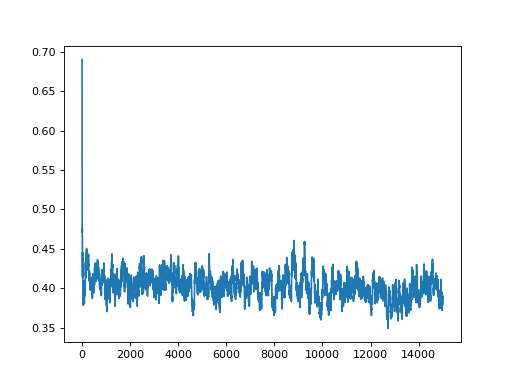

epoch,train_loss,valid_loss,accuracy,time
0,0.424668,0.129029,1.000000,11:18
1,0.393483,0.091236,1.000000,10:51
2,0.382183,0.075696,1.000000,10:45


пожалуйста, позвольте мне пройти
(Category True, tensor(1), tensor([0.4452, 0.5548]))
ненавижу каждого из вас, горите в аду
(Category True, tensor(1), tensor([0.0289, 0.9711]))
пожалуйста, позвольте мне пройти
(Category True, tensor(1), tensor([0.4852, 0.5148]))
ненавижу каждого из вас, горите в аду
(Category True, tensor(1), tensor([0.0363, 0.9637]))
пожалуйста, позвольте мне пройти
(Category True, tensor(1), tensor([0.3988, 0.6012]))
ненавижу каждого из вас, горите в аду
(Category True, tensor(1), tensor([0.0323, 0.9677]))
пожалуйста, позвольте мне пройти
(Category True, tensor(1), tensor([0.4319, 0.5681]))
ненавижу каждого из вас, горите в аду
(Category True, tensor(1), tensor([0.0406, 0.9594]))
пожалуйста, позвольте мне пройти
(Category True, tensor(1), tensor([0.4739, 0.5261]))
ненавижу каждого из вас, горите в аду
(Category True, tensor(1), tensor([0.0391, 0.9609]))
пожалуйста, позвольте мне пройти
(Category True, tensor(1), tensor([0.4653, 0.5347]))
ненавижу каждого из вас, гори

In [31]:
learn_clas.fit_one_cycle(3, best_clf_lr, callbacks=[monitor_callback, sample_callback, stop_after_n_batches])

In [32]:
learn_clas.save("comments_model_4")

<IPython.core.display.Javascript object>


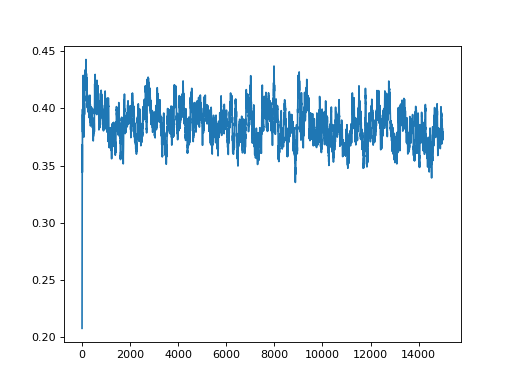

epoch,train_loss,valid_loss,accuracy,time
0,0.389591,0.049181,1.000000,10:08
1,0.387597,0.031268,1.000000,10:51
2,0.372790,0.044546,1.000000,12:54


пожалуйста, позвольте мне пройти
(Category False, tensor(0), tensor([0.5825, 0.4175]))
ненавижу каждого из вас, горите в аду
(Category True, tensor(1), tensor([0.0237, 0.9763]))
пожалуйста, позвольте мне пройти
(Category False, tensor(0), tensor([0.5733, 0.4267]))
ненавижу каждого из вас, горите в аду
(Category True, tensor(1), tensor([0.0237, 0.9763]))
пожалуйста, позвольте мне пройти
(Category False, tensor(0), tensor([0.5511, 0.4489]))
ненавижу каждого из вас, горите в аду
(Category True, tensor(1), tensor([0.0308, 0.9692]))
пожалуйста, позвольте мне пройти
(Category False, tensor(0), tensor([0.6217, 0.3783]))
ненавижу каждого из вас, горите в аду
(Category True, tensor(1), tensor([0.0239, 0.9761]))
пожалуйста, позвольте мне пройти
(Category True, tensor(1), tensor([0.4923, 0.5077]))
ненавижу каждого из вас, горите в аду
(Category True, tensor(1), tensor([0.0173, 0.9827]))
пожалуйста, позвольте мне пройти
(Category False, tensor(0), tensor([0.5842, 0.4158]))
ненавижу каждого из вас,

In [33]:
learn_clas.fit_one_cycle(3, best_clf_lr, callbacks=[monitor_callback, sample_callback, stop_after_n_batches])

In [34]:
learn_clas.save("comments_model_5")

# Predictions for the test set

I'm doing it very inefficiently - one instance at a time

**How to do better:** in a mini-batch manner. 

In [35]:
txt_ci = TextClassificationInterpretation.from_learner(learn_clas)

KeyboardInterrupt: 

In [49]:
test_text = "онлайнер говно"

In [50]:
learn_clas.predict(item=test_text)

(Category True, tensor(1), tensor([0.2528, 0.7472]))

In [51]:
txt_ci.show_intrinsic_attention(test_text)

In [40]:
test_comments = pd.read_csv("./test.csv")

In [42]:
predictions = []
for message in tqdm_notebook(test_comments["text"]):
    predictions.append(learn_clas.predict(item=message))

KeyboardInterrupt: 

In [22]:
predictions = [p[2][-1] for p in predictions]

In [23]:
test_comments["new_toxic"] = [float(p) for p in predictions]

In [24]:
test_comments["toxic_difference"] = np.abs(test_comments["toxic"] / 100 - test_comments["new_toxic"])

In [27]:
test_comments.sort_values("new_toxic", ascending=False)[0:100]

,Unnamed: 0,_id,checked,message,timestamp,toxic,userId,userName,new_toxic,toxic_difference
264,264,5cc17b7f79f829638920c5c2,0.0,https://ролики.ком,1.556184e+12,27.70,427133012,lexaich07,0.998641,0.721641
475,475,5cc19480adb83f704f924289,0.0,"Твоя мамка - чёрная еврейская хохлуха, твой от...",1.556190e+12,96.01,156724583,NaN,0.996713,0.036613
92,92,5cc17373a341cf099cea138b,0.0,"Ублюдок, мать твою, а ну иди сюда, говно собач...",1.556182e+12,93.34,408947347,max_tkachuk,0.996500,0.063100
415,415,5cc189e379f829638920c65b,0.0,Все тебя ненавидят черное ничтожество беспомощ...,1.556188e+12,99.89,427912372,NaN,0.995407,0.003493
390,390,5cc1884c79f829638920c642,0.0,Все тебя ненавидят черное ничтожество беспомощ...,1.556187e+12,99.89,427912372,NaN,0.995245,0.003655
480,480,5cc1952fadb83f704f92428e,0.0,"Твоя мамка - чёрная еврейская хохлуха, твой от...",1.556191e+12,96.15,156724583,NaN,0.995008,0.033508
712,712,5cc84b7e6cefec7762b9e65f,0.0,ты че совсем тупой? слона купи,1.556630e+12,46.70,795114316,NaN,0.994097,0.527097
162,162,5cc175fea341cf099cea13d5,0.0,"Ублюдок, мать твою, а ну иди сюда! Что, решил ...",1.556183e+12,99.91,408947347,max_tkachuk,0.993533,0.005567
72,72,5cc17137a341cf099cea1363,0.0,Идиот тупой глупый проходимец недоделанный,1.556181e+12,64.28,881508391,NaN,0.993357,0.350557
461,461,5cc19160adb83f704f92427b,0.0,/s,1.556190e+12,20.28,123616566,bone_2001,0.993324,0.790524
